In [1]:
# If you're in Colab and need statsmodels:
# !pip install statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
from pandas.plotting import scatter_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

np.random.seed(8675309)



Summary of dat:
                x1           x2       y_norm        y_het
count  1000.000000  1000.000000  1000.000000  1000.000000
mean      6.985207     3.424689    48.343856    47.442763
std       2.992218     6.893406    25.807478    40.755850
min      -1.071681   -18.417960   -28.852280   -50.004583
25%       5.095901    -1.036071    31.105878    18.379436
50%       7.132485     3.385617    48.373294    40.755108
75%       8.952404     7.827421    65.633600    70.187938
max      19.041411    24.737906   130.793503   246.105977


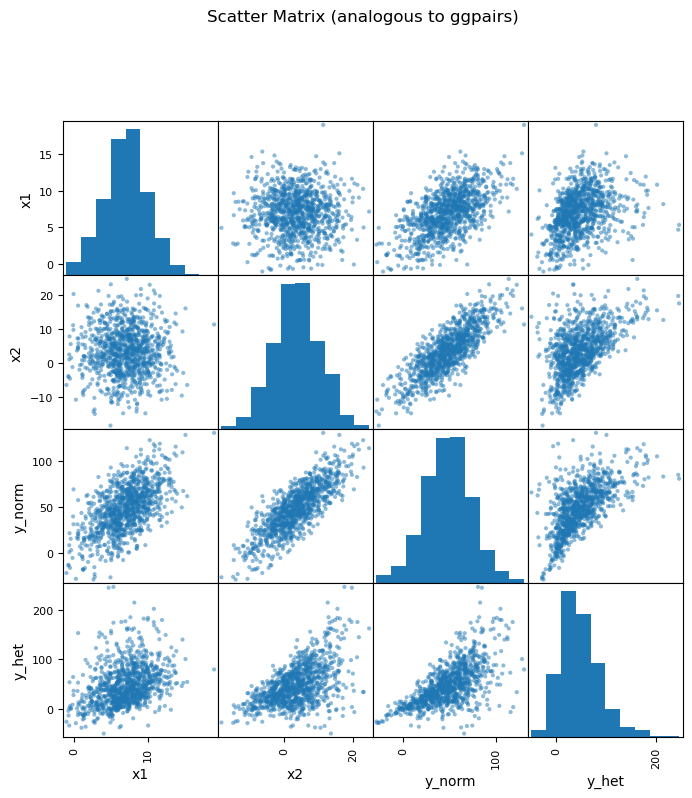

In [2]:
# ---------------------------------------------------------
# Create data
# ---------------------------------------------------------
n = 1000

x1 = np.random.normal(loc=7, scale=3, size=n)
x2 = np.random.normal(loc=3, scale=7, size=n)

# Homoskedastic y
y_norm = 3 + 5 * x1 + 3 * x2 + np.random.normal(loc=0, scale=2.5, size=n)

# Heteroskedastic y: variance depends on x2
x2_min = x2.min()
x2_max = x2.max()
q = (x2 - x2_min) / (x2_max - x2_min)  # scaled to [0,1]

noise_het = np.array([np.random.normal(loc=0, scale=(qi**2) * 100) for qi in q])
y_het = 3 + 5 * x1 + 3 * x2 + noise_het

dat = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y_norm": y_norm,
    "y_het": y_het
})

print("Summary of dat:")
print(dat.describe())

# Pairs plot
scatter_matrix(dat, figsize=(8, 8), diagonal="hist")
plt.suptitle("Scatter Matrix (analogous to ggpairs)", y=1.02)
plt.show()




OLS summary for heteroskedastic model (f_het):
                            OLS Regression Results                            
Dep. Variable:                  y_het   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     333.6
Date:                Sat, 08 Nov 2025   Prob (F-statistic):          1.17e-111
Time:                        14:15:03   Log-Likelihood:                -4869.8
No. Observations:                1000   AIC:                             9746.
Df Residuals:                     997   BIC:                             9760.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inte

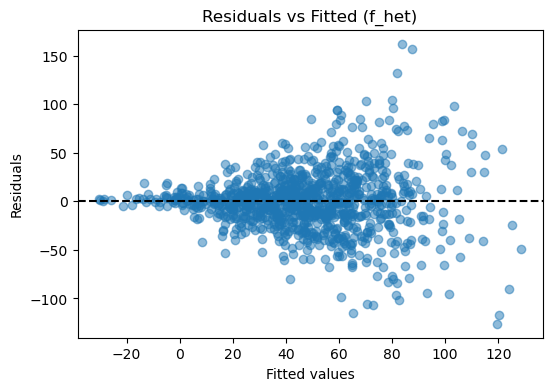

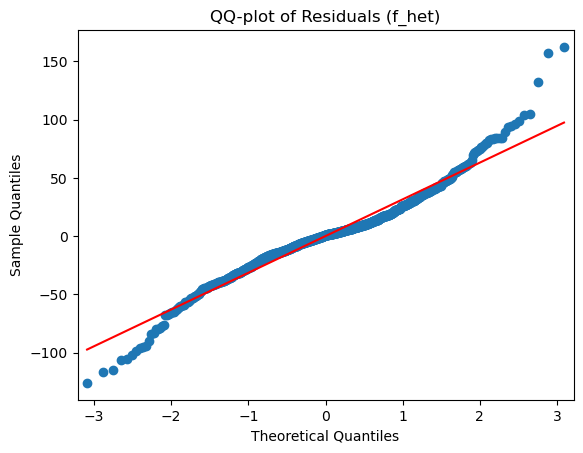

In [3]:
# ---------------------------------------------------------
# Fit a model: y_het ~ x1 + x2
# ---------------------------------------------------------
f_het = smf.ols("y_het ~ x1 + x2", data=dat).fit()

print("\nOLS summary for heteroskedastic model (f_het):")
print(f_het.summary())

# Rough analog to plot(f_het): residuals vs fitted, QQ plot
plt.figure(figsize=(6, 4))
plt.scatter(f_het.fittedvalues, f_het.resid, alpha=0.5)
plt.axhline(0, color="k", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (f_het)")
plt.show()

sm.qqplot(f_het.resid, line="s")  # "s" = standardized line (R-like)
plt.title("QQ-plot of Residuals (f_het)")
plt.show()



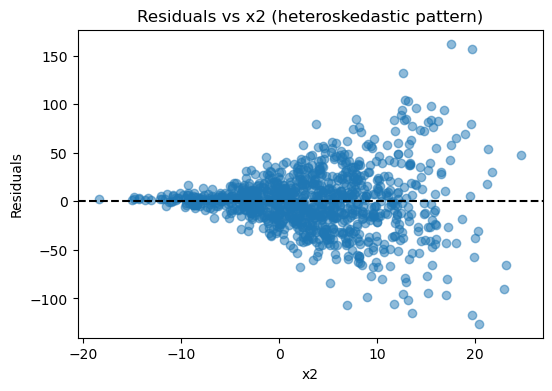

In [4]:
# ---------------------------------------------------------
# We know heteroskedasticity comes from x2: plot x2 vs residuals
# ---------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.scatter(dat["x2"], f_het.resid, alpha=0.5)
plt.axhline(0, color="k", linestyle="--")
plt.xlabel("x2")
plt.ylabel("Residuals")
plt.title("Residuals vs x2 (heteroskedastic pattern)")
plt.show()




In [5]:
# ---------------------------------------------------------
# Breusch–Pagan test against heteroskedasticity
# ---------------------------------------------------------
bp_test = sms.het_breuschpagan(f_het.resid, f_het.model.exog)
bp_labels = ["LM stat", "LM p-value", "F stat", "F p-value"]
print("\nBreusch–Pagan test for heteroskedasticity (y_het ~ x1 + x2):")
print(dict(zip(bp_labels, bp_test)))




Breusch–Pagan test for heteroskedasticity (y_het ~ x1 + x2):
{'LM stat': np.float64(189.17501114087122), 'LM p-value': np.float64(8.340042692099369e-42), 'F stat': np.float64(116.30591601082047), 'F p-value': np.float64(3.982645939624782e-46)}


In [6]:
# ---------------------------------------------------------
# Robust standard errors (HC0), analogous to coeftest + vcovHC
# ---------------------------------------------------------
f_het_robust = f_het.get_robustcov_results(cov_type="HC0")

print("\nOLS with robust (HC0) standard errors:")
print(f_het_robust.summary())


OLS with robust (HC0) standard errors:
                            OLS Regression Results                            
Dep. Variable:                  y_het   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     237.7
Date:                Sat, 08 Nov 2025   Prob (F-statistic):           3.83e-85
Time:                        14:15:20   Log-Likelihood:                -4869.8
No. Observations:                1000   AIC:                             9746.
Df Residuals:                     997   BIC:                             9760.
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   